In [1]:
import time
from functools import partial
from typing import Generator, Sequence
import numpy as np
import matplotlib.pyplot as plt
from mlx import core as mx, nn, optimizers

# Load and Process Data

In [2]:
with open('../data/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

Tokens are chars, so the vocab size is the number of unique chars

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

char2int = {c: i for i, c in enumerate(chars)}
int2char = {i: c for i, c in enumerate(chars)}


def encode(s: str) -> list[int]:
    return [char2int[c] for c in s if c in char2int]


def decode(y: list[int] | np.ndarray | mx.array) -> str:
    if isinstance(y, mx.array):
        y = np.array(y)
    return "".join([int2char[int(i)] for i in y if int(i) in int2char])

The input text is encoded as an `mx.array`, then split into training and validation
splits

In [4]:
full_data = mx.array(encode(text), dtype=mx.int64)

val_size = len(full_data) // 10

train_data = full_data[val_size:]
val_data = full_data[:val_size]

### Convert data into blocks

$x_i = [d_i, d_{i + 1}, ..., d_{i + b}]$

$y_i = [d_{i + 1}, d_{i + 2}, ..., d_{i + b + 1}]$

In [5]:
def block_data(data: mx.array, block_size: int) -> tuple[mx.array, mx.array]:
    n_blocks = len(data) - block_size - 1
    x = mx.stack([data[i:i + block_size] for i in range(n_blocks)])
    y = mx.stack([data[i:i + block_size] for i in range(1, n_blocks + 1)])
    mx.eval(x, y)
    return x, y

### Generate random batches for dataset

In [6]:
def batch_iterate(
    x: mx.array, 
    y: mx.array, 
    batch_size: int,
) -> Generator[tuple[mx.array, mx.array], None, None]:
    permutation = mx.array(np.random.permutation(y.shape[0]))
    for s in range(0, y.shape[0], batch_size):
        idxs = permutation[s:s + batch_size]
        bx = x[idxs]
        by = y[idxs]
        mx.eval(bx, by)
        yield bx, by

# Model

### Layer Normalization

$y = \frac{x - E[x]}{\sqrt{E[(x - E[x])^2] + \epsilon}} \odot \gamma + \beta$

In [7]:
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape: Sequence[int], bias=True, eps=1e-5) -> None:
        super().__init__()
        self.weight = mx.ones(normalized_shape)
        self.bias = mx.ones(normalized_shape) if bias else None
        self.eps = eps
    

    def __call__(self, x: mx.array): 
        return mx.fast.layer_norm(x, self.weight, self.bias, self.eps) 

### Self Attention

$[q_{i, j}, k_{i, j}, v_{i, j}] = x_{i, j}[W_q, W_k, W_v] + [b_q, b_k, b_v]$ 
where all $q, k, v, x, b$ are row vectors

$[q_{i, j}, k_{i, j}, v_{i, j}]$ are computed for $x_i$ in the 3D tensor 
$x = \begin{bmatrix}
x_{1, 1} & \dots & x_{1, T} \\
\vdots & \ddots & \vdots \\
x_{B, 1} & \dots & x_{B, T}
\end{bmatrix}$ resulting in tensors $q, k, v$

$x$ has shape $(B, T, C)$ where $B$ is the batch size, $T$ is the sequence length,
and $C$ is the number of embedding dimensions

$q, k, v$ have shape $(B, T, ND)$ where $B$ is the batch size, 
$T$ is the sequence length, $N$ is the number of attention heads, and $D$ is the
number of query/key dimensions

$q, k, v$ are reshaped to $(B, N, T, D)$

$a_{i, j} = q_{i, j} k_{i, j}^T$

$a_{i, j} = -\infty$ for all $i < j$

$a_{i, j} = \text{softmax}(a_{i, j})$ where softmax is computed rowwise

$y_{i, j} = a_{i, j} v_{i, j}$

$y$ has shape $(B, N, T, D)$

$y$ is reshaped to $(B, T, ND)$, so $y_{i, j}$ is a row vector

$y_{i, j} = y_{i, j}W_p + b_p$ 

In [8]:
class SelfAttention(nn.Module):
    def __init__(
        self, n_embed: int, n_head: int, 
        mask: mx.array, dropout: float, bias=True
    ) -> None:
        super().__init__()
        self.n_embed = n_embed
        self.n_head = n_head
        assert n_embed % n_head == 0 
        self.D = n_embed // n_head

        self.c_attn = nn.Linear(n_embed, 3 * n_embed, bias=bias)
        self.c_proj = nn.Linear(n_embed, n_embed, bias=bias)
        self.dropout = nn.Dropout(dropout)

        self.mask = mask
        self.scale = 1.0 / np.sqrt(self.D)
    

    def __call__(self, x: mx.array):
        B, T, n_embed = x.shape
        assert n_embed == self.n_embed

        tmp = self.c_attn(x)
        tmp = tmp.split(self.n_embed, axis=2)

        q, k, v = mx.split(self.c_attn(x), 3, axis=2)

        # reshape to (B, N, T, D)
        q = q.reshape((B, T, self.n_head, self.D)).transpose((0, 2, 1, 3)) 
        k = k.reshape((B, T, self.n_head, self.D)).transpose((0, 2, 1, 3))
        v = v.reshape((B, T, self.n_head, self.D)).transpose((0, 2, 1, 3))
        
        y = mx.fast.scaled_dot_product_attention(
            q, k, v, 
            mask=self.mask[:T, :T], 
            scale=self.scale,
        )
        
        y = y.transpose((0, 2, 1, 3)).reshape((B, T, self.n_embed)) # concat head outputs 
        y = self.c_proj(y)
        y = self.dropout(y)
        return y

### MLP

$x_{i, j} = x_{i, j} W_{c} + B_{c}$

$y_{i, j} = x_{i, j} W_{p} + B_{p}$

In [9]:
class MLP(nn.Module):
    def __init__(self, n_embed: int, dropout: float, bias=True) -> None:
        super().__init__()
        self.c_fc = nn.Linear(n_embed, 4 * n_embed, bias=bias)
        self.c_proj = nn.Linear(4 * n_embed, n_embed, bias=bias)
        self.dropout = nn.Dropout(dropout)


    def __call__(self, x: mx.array):
        x = nn.gelu(self.c_fc(x))
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

### Block

Composition of layer normalization, self attention, and mlp

In [10]:
class Block(nn.Module):
    def __init__(
        self, n_embed: int, n_head: int, 
        mask: mx.array, dropout: float, bias=True,
    ) -> None:
        super().__init__()
        self.ln_1 = LayerNorm(n_embed, bias=bias)
        self.attn = SelfAttention(n_embed, n_head, mask, dropout, bias)
        self.ln_2 = LayerNorm(n_embed, bias=bias)
        self.mlp = MLP(n_embed, dropout, bias)


    def __call__(self, x: mx.array):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

### Generative Transformer
- Input is an array of token indexes
- Computes token embeddings from the input
- Computes position embeddings from the sequence $[0, 1, ..., T - 1]$
- $x$ is the sum of the token and position embeddings
- $x$ is forwarded through all the blocks
- $x$ is layer normalized one more time
- $x$ is forwarded through a linear layer to transform it from the embedding dimension 
    to the vocab size
- If generating, $p = \text{softmax}(x)$, and the next index is drawn from the 
    distribution $p$

In [11]:
class GenerativeTransformer(nn.Module):
    def __init__(
        self, n_embed: int, n_head: int, block_size: int, 
        vocab_size: int, n_layer: int, dropout: float, bias=True,
    ) -> None:
        super().__init__()
        self.block_size = block_size
        self.wte = nn.Embedding(vocab_size, n_embed)
        self.wpe = nn.Embedding(block_size, n_embed)
        self.drop = nn.Dropout(dropout)

        mask = np.zeros((block_size, block_size), dtype=np.float32)
        mask[np.tril(np.ones((block_size, block_size))) == 0] = -np.inf
        mask = mx.array(mask)
        
        self.h = [Block(n_embed, n_head, mask, dropout, bias) for _ in range(n_layer)]
        self.ln_f = LayerNorm(n_embed, bias=bias)

        self.lm_head = nn.Linear(n_embed, vocab_size, bias=False)
        self.wte.weight = self.lm_head.weight

        def init_weights(_, m: nn.Module):
            if isinstance(m, nn.Linear) or isinstance(m, nn.Embedding):
                m.weight = nn.init.normal(0.0, 0.02)(m.weight)
                if hasattr(m, "bias") and m.bias is not None:
                    m.bias = mx.zeros_like(m.bias)
        

        self.apply_to_modules(init_weights)
                
    

    def __call__(self, x_idx: mx.array):
        _, T = x_idx.shape

        assert T <= self.block_size, \
            f"cannot forward sequence of length {T}, block size is only {self.block_size}"
        
        pos = mx.arange(0, T, dtype=mx.int64)

        tok_emb = self.wte(x_idx) # shape (B, T, C)
        pos_emb = self.wpe(pos) # shape (T, C)

        # (B, T, C) + (T, C) = (B, T, C)
        # elementwise addition for each batch
        x = self.drop(tok_emb + pos_emb)
        for blk in self.h:
            x = blk(x)
        x = self.ln_f(x)
        x = self.lm_head(x)
        return x
    

    def generate(self, x_idx: mx.array, max_new_tokens: int, temperature=1.0):
        # Take a conditioning sequence of indices x_idx (int64 tensor of shape (B, T)) and 
        # complete the sequence max_new_tokens times, feeding the predictions back into 
        # the model each time. Most likely you"ll want to make sure to be in model.eval() 
        # mode of operation for this.
        for _ in range(max_new_tokens):
            if x_idx.shape[1] <= self.block_size:
                x_idx_cropped = x_idx 
            else:
                x_idx_cropped = x_idx[:, -self.block_size:]

            logits = self(x_idx_cropped)
            logits = logits[:, -1, :] / temperature
            next_idx = mx.random.categorical(logits)[None]
            x_idx = mx.concatenate((x_idx, next_idx), axis=1)
        return x_idx  

# Training

In [12]:
EVAL_INTERVAL = 2500
LOG_INTERVAL = 500

BLOCK_SIZE = 32
BATCH_SIZE = 16

DTYPE = mx.float32

MAX_ITERS = 10000

MAX_LR = 1e-4
WARMUP_ITERS = 100
LR_DECAY_ITERS = 2500
MIN_LR = 1e-5

### Convert data to blocks

$x_i = [d_i, d_{i + 1}, ..., d_{i + b}]$

$y_i = [d_{i + 1}, d_{i + 2}, ..., d_{i + b + 1}]$

In [13]:
x_train, y_train = block_data(train_data, BLOCK_SIZE)
x_val, y_val = block_data(val_data, BLOCK_SIZE)

### Initialize model, optimizer, and training state

In [14]:
model = GenerativeTransformer(
    n_embed=640, # changed so n_embed % n_head == 0
    n_head=4, 
    block_size=BLOCK_SIZE, 
    vocab_size=vocab_size,
    n_layer=4, 
    dropout=0.0, 
    bias=True,
)

# model.load_weights("checkpoints/model.npz")

model.set_dtype(DTYPE)

optimizer = optimizers.AdamW(1e-3, (0.9, 0.95), 1e-7, 0.1)

state = [model.state, optimizer.state]

mx.eval(state)

### Change learning rate over time

$\eta_i = \begin{cases}
    \frac{\eta \cdot i}{N_{\text{warmup}}} & i < N_{\text{warmup}} \\
    \eta_{\text{min}} + \left(
        \frac{1}{2} + \frac{1}{2}\cos\left(
            \pi \frac{N_{\text{warmup}} \cdot i}{N_{\text{decay}} - N_{\text{warmup}}}
        \right)
    \right)(\eta_0 - \eta_{\text{min}}) & N_{\text{warmup}} \leq i < N_{\text{decay}} \\
    \eta_{\text{min}} & N_{\text{decay}} \leq i
\end{cases}$

In [15]:
def get_lr(iter_num: int) -> float:
    if iter_num < WARMUP_ITERS: 
        return MAX_LR * iter_num / WARMUP_ITERS 
    
    if iter_num > LR_DECAY_ITERS:
        return MIN_LR
    
    decay_ratio = (iter_num - WARMUP_ITERS) / (LR_DECAY_ITERS - WARMUP_ITERS)
    assert 0 <= decay_ratio and decay_ratio <= 1
    coeff = 0.5 * (1.0 + np.cos(np.pi * decay_ratio))
    return MIN_LR + coeff * (MAX_LR - MIN_LR)

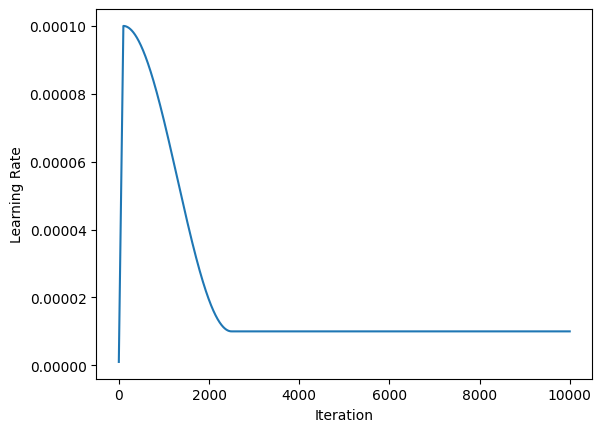

In [16]:
plt.plot([get_lr(i) for i in range(1, MAX_ITERS + 1)])
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.show()

### Crossentropy loss:

$l(x, y, \theta) = -\sum_i y_i \log(f(x_i, \theta))$

<br>

### Train Step with Adam Optimizer

$g_t = \nabla_{\theta_{t - 1}} l(x, y, )$

$\alpha = \eta \frac{\sqrt{1 - \beta_2^t}}{1 - \beta_1^t}$

$m_t = \beta_1 m_{t - 1} + (1 - \beta_1)g_t$

$m_t = \beta_2 v_{t - 1} + (1 - \beta_2)g_t^2$

$\theta_t = \theta_{t - 1} - \alpha \frac{m_t}{\sqrt{v_t} + \epsilon}$

In [17]:
def loss_fn(model, x, y):
    return nn.losses.cross_entropy(model(x), y, reduction="mean")


@partial(mx.compile, inputs=state, outputs=state)
def train_step(x, y):
    loss, grads = nn.value_and_grad(model, loss_fn)(model, x, y)
    optimizer.update(model, grads)
    return loss


@partial(mx.compile, inputs=state)
def eval_step(x, y):
    return loss_fn(model, x, y)


def evaluate_loss(x, y, max_iters=100):
    loss_sum = 0
    cnt = 0
    for i, (bx, by) in enumerate(batch_iterate(x, y, BATCH_SIZE)):
        if i >= max_iters:
            break
        loss = eval_step(bx, by)
        loss_sum += loss * len(x)
        cnt += len(x)
    loss = loss_sum / cnt
    mx.eval(loss)
    return loss.item()

### Training loop

In [18]:
i = 1
t0 = time.time()
best_val_loss = float('inf')

while True:
    if i > MAX_ITERS:
        break
     
    for x, y in batch_iterate(x_train, y_train, batch_size=BATCH_SIZE):
        if i > MAX_ITERS:
            break
        
        optimizer.learning_rate = get_lr(i)

        loss = train_step(x, y)
        mx.eval(state)

        if i % LOG_INTERVAL == 0:
            t1 = time.time()
            dt = t1 - t0
            t0 = t1
            print(f"[{i:4}] loss: {loss.item():.3f}, time: {dt:.3f}s")
        
        if i % EVAL_INTERVAL == 0:
            train_loss = evaluate_loss(x_train, y_train)
            val_loss = evaluate_loss(x_val, y_val)
            print(f"    train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                model.save_weights(f"checkpoints/model1.npz")   
                print(f"    saved model to checkpoints")

        i += 1   

# float32:
# 4m 31.3s
# train loss: 1.4603, val loss: 1.5795

# bfloat16:
# 3m 48.1s
# train loss: 1.8359, val loss: 1.9062

[ 500] loss: 2.219, time: 11.289s
[1000] loss: 2.031, time: 11.067s
[1500] loss: 1.844, time: 11.152s
[2000] loss: 2.000, time: 11.149s
[2500] loss: 1.859, time: 11.151s
    train loss: 1.9141, val loss: 1.9297
    saved model to checkpoints
[3000] loss: 1.852, time: 12.429s
[3500] loss: 1.781, time: 11.153s
[4000] loss: 1.789, time: 11.164s
[4500] loss: 1.859, time: 11.172s
[5000] loss: 1.875, time: 11.162s
    train loss: 1.8750, val loss: 1.8906
    saved model to checkpoints
[5500] loss: 1.781, time: 12.432s
[6000] loss: 1.805, time: 11.154s
[6500] loss: 1.781, time: 11.155s
[7000] loss: 1.664, time: 11.153s
[7500] loss: 1.906, time: 11.149s
    train loss: 1.8516, val loss: 1.9141
[8000] loss: 1.742, time: 12.388s
[8500] loss: 1.734, time: 11.140s
[9000] loss: 1.711, time: 11.141s
[9500] loss: 1.867, time: 11.142s
[10000] loss: 1.781, time: 11.148s
    train loss: 1.8672, val loss: 1.9141


# 

# Testing

In [19]:
train_loss = evaluate_loss(x_train, y_train)
val_loss = evaluate_loss(x_val, y_val)
print(f"train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

train loss: 1.8359, val loss: 1.9062


In [20]:
context = mx.array(encode("Hello, my name is"))[None]
output = model.generate(context, max_new_tokens=100, temperature=1)
mx.eval(output)
print(decode(output[0]))

Hello, my name is Tay the beann.

HENRY VILOCK:
Neet freing and elger-NET:
And no fork, housh thim wear promes.
'KINI
